## Word cloud analysis

Class 1 mostly mispredicted as class 2
Class 2 mostly mispredicted as class 3
Class 3 mostly mispredicted as class 4

## Analysis of why class 1 mispredicted by class 2

In [31]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction import text
from nltk.tokenize import word_tokenize
from collections import Counter

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')
def  error_error_analysis(misclassified, title="Word Cloud of Misclassified Text"):
  # plot word cloud
  # Extract text from the 'Text' column of misclassified instances
  text_data = ' '.join(misclassified['Text'])
  # Generate word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
  # Plot word cloud
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title)
  plt.show()
  # Get English stopwords
  stop_words = set(text.ENGLISH_STOP_WORDS)
  # Tokenize the text data
  tokens = word_tokenize(text_data)
  # Filter out stopwords, punctuation, and lowercase the words
  words = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
  # Count the occurrences of each word
  word_counts = Counter(words)
  # Find the most common word
  # Find the 10 most common words
  most_common_words = word_counts.most_common(8)
  print("10 most frequent words:")
  for word, count in most_common_words:
      print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinhoe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class 2 mispredicted as class 3 likely due to words People, One, Even

In [ ]:
# Check for class imbalances
class_distribution = df['predicted'].value_counts()
print(class_distribution)

predicted
3    211
2    187
4    137
1    108
Name: count, dtype: int64


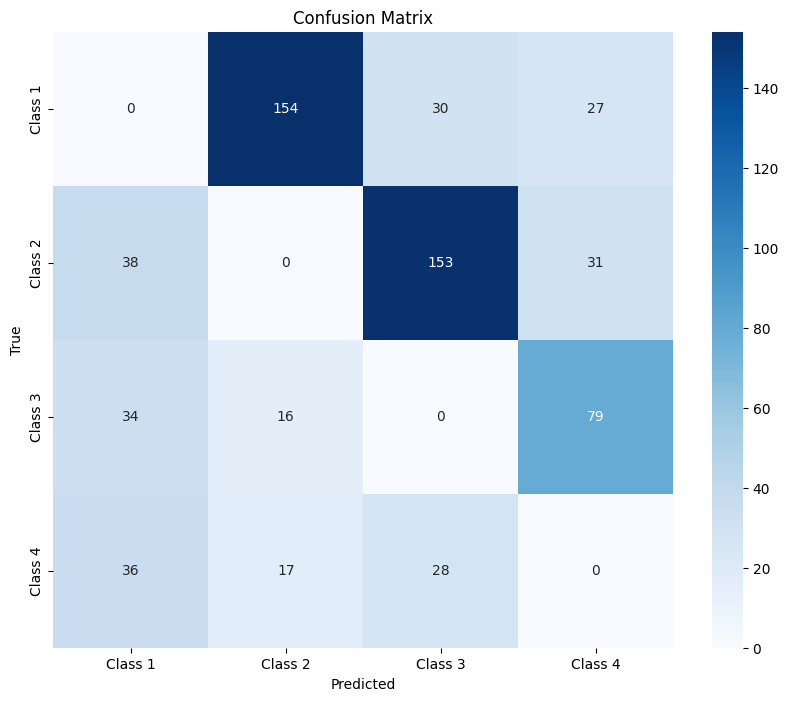

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(df['Verdict'], df['predicted'])
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## TFIDF Analysis

/Users/justinhoe/Desktop/Y4S2/4248/LUN/proj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.83      0.72      0.77       750
           2       0.74      0.70      0.72       750
           3       0.75      0.83      0.79       750
           4       0.83      0.89      0.86       750

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.79      0.79      0.78      3000

0.7843630006585706


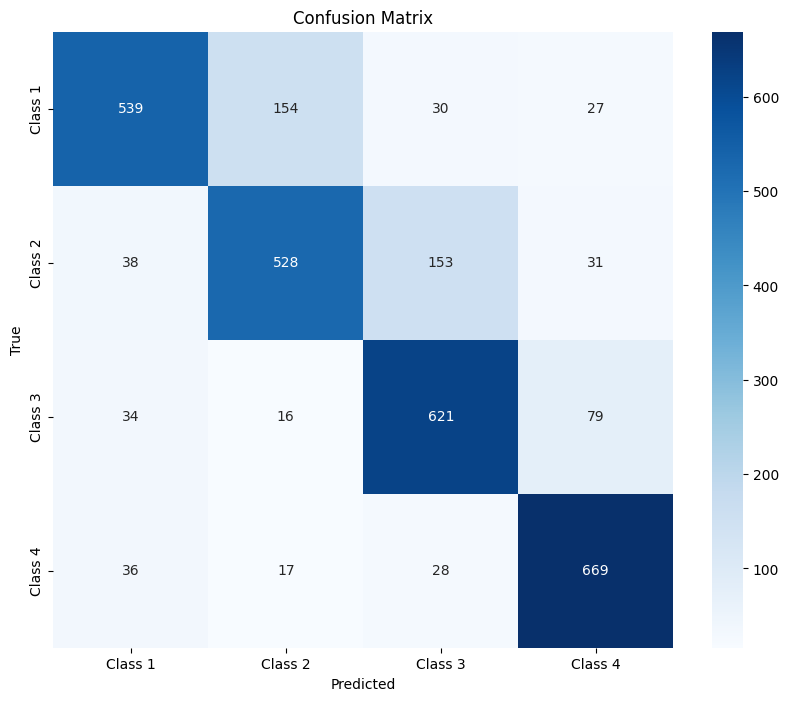

In [9]:
import pandas as pd
from sklearn.metrics import f1_score
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Below files can all be retreived at https://drive.google.com/drive/folders/12EcyvolndIrlnazvdM1zxQbcctoQiTYQ
train_df = pd.read_pickle("./compiled.pkl")
test_df = pd.read_pickle("./compiled_test.pkl")
test_df.columns
# train_df = train_df.loc[:,~train_df.columns.duplicated()].copy()
misclassified_df = pd.read_pickle('./compiled_test_with_predictions.pkl')

def tai_model(df_train, df_test, extra_stop_words=[]):
  def get_feature_from_df(df):
      columns = ['sentiment_compound_score',
        'number_of_words', 'number_of_characters', 'number_of_sentence',
          'DATE', 
        'LANGUAGE', 'GPE', 'WORK_OF_ART', 'NORP', 'ORDINAL', 'LOC', 'CARDINAL',
        'FAC', 'PERCENT', 'LAW', 'QUANTITY', 'EVENT', 'PERSON', 'PRODUCT',
        'MONEY', 'ORG', 'TIME', 'total_entities', 'readability']

      features = []
      for col in columns:
          features.append(list(df[col]))
      # features.append(list(number_of_capitalized))
      return features

  df_train = df_train.loc[:,~df_train.columns.duplicated()].copy()
  features_train = get_feature_from_df(df_train)

  # we need to reshape it to become (n_samples, n_features)
  features_train = list(map(list, zip(*features_train)))
  scaler = MinMaxScaler()
  features_train = scaler.fit_transform(features_train)

  # Custom stop words
  sw = list(text.ENGLISH_STOP_WORDS.union(extra_stop_words))
  # Step 1: Convert texts to TF-IDF features
  
  vectorizer = TfidfVectorizer(stop_words=sw, lowercase=True)

  tfidf_train = vectorizer.fit_transform(df_train["Text"])

  # Combine the text features with the extracted features
  from scipy.sparse import hstack
  X = hstack([tfidf_train, features_train])

  # print("features_train start from " + str(tfidf_train.shape[1]) + " to " + str(X.shape[1]))

  # Step 2: Apply Chi-squared test
  chi2score = chi2(X, df_train['Verdict'])

  # Step 3: Select the top 60k features
  chi2_selector = SelectKBest(chi2, k=60000)
  X_kbest_features = chi2_selector.fit_transform(X, df_train['Verdict'])

  # get the selected feature names
  feature_names = chi2_selector.get_feature_names_out()

  feature_cols = ['sentiment_compound_score',
        'number_of_words', 'number_of_characters', 'number_of_sentence',
          'DATE', 
        'LANGUAGE', 'GPE', 'WORK_OF_ART', 'NORP', 'ORDINAL', 'LOC', 'CARDINAL',
        'FAC', 'PERCENT', 'LAW', 'QUANTITY', 'EVENT', 'PERSON', 'PRODUCT',
        'MONEY', 'ORG', 'TIME', 'total_entities', 'readability']
  # see the selected features
  for i in range(len(feature_names)):
      name = feature_names[i]
      number = name.split('x')[1]
      if int(number) in range(tfidf_train.shape[1], X.shape[1]):
          # print("tfidf: " + str(feature_names[i]))

          index = int(str(feature_names[i]).split('x')[1]) - tfidf_train.shape[1]
          # print(feature_cols[index])
  class_weights = {1: 2,  # Class 0
                  2: 4,  # Class 1
                  3: 2, # Class 2 (Assuming this is the underrepresented class)
                  4: 2}  # Class 3
  model = LogisticRegression(class_weight=class_weights)
  model.fit(X_kbest_features, df_train['Verdict'])
  # Step 1: Convert texts to TF-IDF featu res
  # df_test["Text"] = df_test["Text"].apply(preprocessing)
  X_test = vectorizer.transform(df_test["Text"])
  features_test = get_feature_from_df(df_test)

  # we need to reshape it to become (n_samples, n_features)
  features_test = list(map(list, zip(*features_test)))
  features_test = scaler.transform(features_test)

  X_test = hstack([X_test, features_test])

  # Get the top 1000 features as above
  X_test_kbest_features = chi2_selector.transform(X_test)
  # X_test_kbest_features = X_test

  # Step 4: Predict the class of the new texts
  predicted_classes = model.predict(X_test_kbest_features)
  df_test['predicted'] = predicted_classes

  # Assuming df_test["Class"] contains the true class of the new texts
  print(classification_report(df_test["Verdict"], predicted_classes))
  print(f1_score(df_test["Verdict"], predicted_classes, average='macro'))
  
  conf_matrix = confusion_matrix(df_test['Verdict'], predicted_classes)
  class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()
  return df_test

base_model_df = tai_model(train_df, test_df)

 ### Analysis of why class 1 mispredicted by class 2


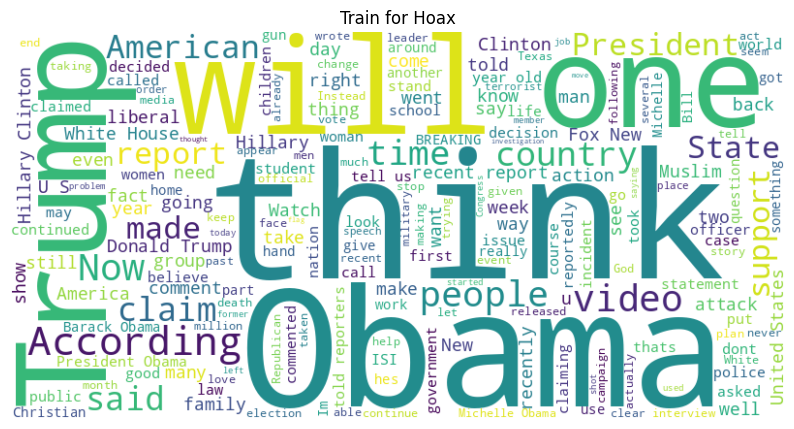

10 most frequent words:
obama: 4103
think: 3622
trump: 2704
just: 2202
president: 1983
according: 1793
video: 1791
people: 1688


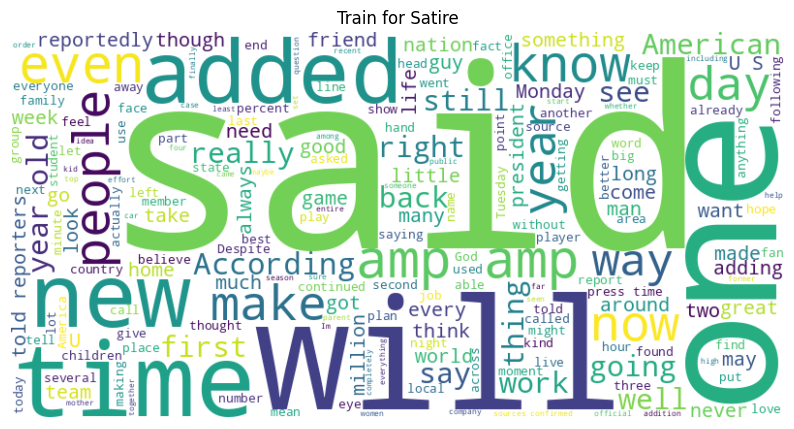

10 most frequent words:
said: 9999
just: 3511
time: 2961
like: 2543
new: 2044
added: 1753
amp: 1606
people: 1495


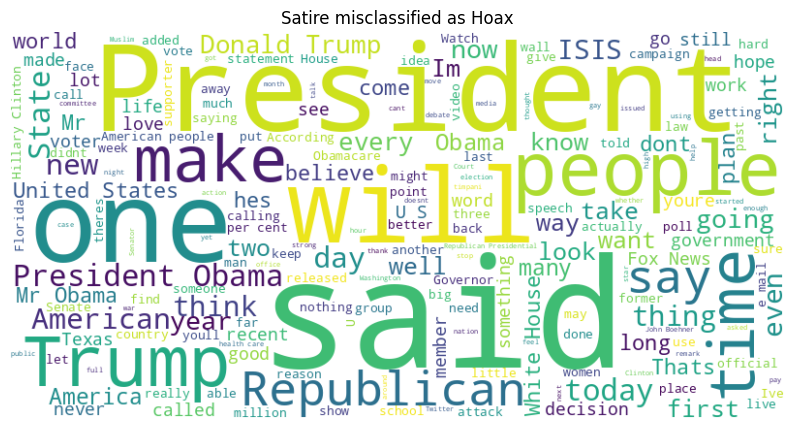

10 most frequent words:
said: 222
president: 179
obama: 118
people: 116
trump: 114
just: 92
like: 91
state: 63


In [33]:
error_error_analysis(train_df[train_df['Verdict'] == 2], title="Train for Hoax")
error_error_analysis(train_df[train_df['Verdict'] == 1], title="Train for Satire")
error_error_analysis(misclassified_df[(misclassified_df['Verdict'] == 1) & (misclassified_df['predicted'] == 2)], title="Satire misclassified as Hoax")


Findings: Class 1 mis-classified as class 2 likely due to words Obama, people, president, trump

/Users/justinhoe/Desktop/Y4S2/4248/LUN/proj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.83      0.71      0.77       750
           2       0.74      0.70      0.72       750
           3       0.75      0.82      0.78       750
           4       0.82      0.89      0.85       750

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000

0.77994746818226


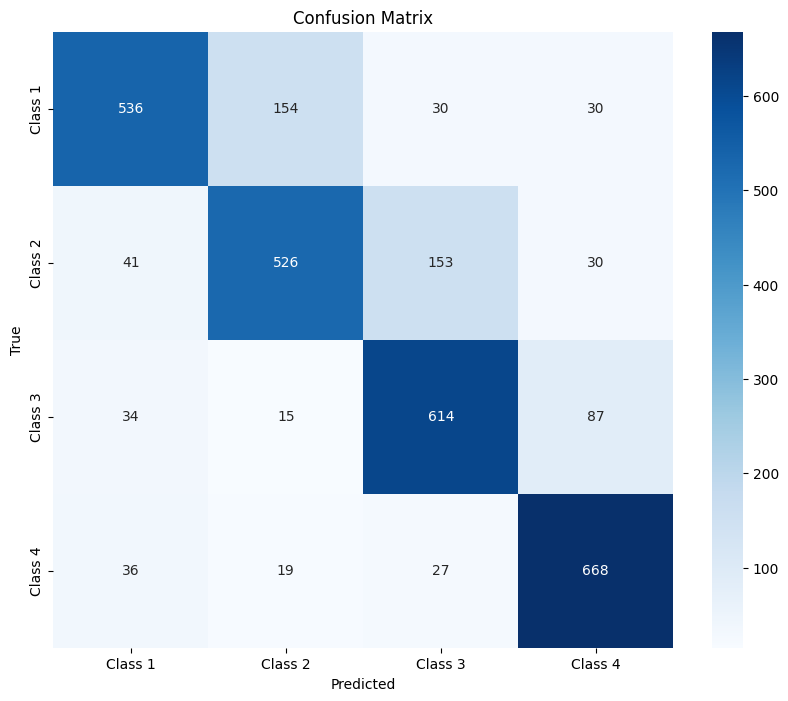

,Verdict,Text,sentiment,sentiment_compound_score,number_of_words,number_of_characters,number_of_sentence,ORDINAL,DATE,GPE,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,predicted
0,1,When so many actors seem content to churn out ...,"{'neg': 0.076, 'neu': 0.851, 'pos': 0.073, 'co...",-0.4526,251,1356,14,0,2,1,...,0,0,0,0,0,0,0,0,0,1
1,1,In what football insiders are calling an unex...,"{'neg': 0.159, 'neu': 0.777, 'pos': 0.064, 'co...",-0.9601,202,1173,15,0,2,2,...,21,11,47,14,63,59,16,7,58,1
2,1,In a freak accident following Game 3 of the N....,"{'neg': 0.085, 'neu': 0.805, 'pos': 0.11, 'com...",0.6644,167,979,9,0,2,1,...,13,14,15,5,29,16,11,7,6,1
3,1,North Koreas official news agency announced to...,"{'neg': 0.1, 'neu': 0.789, 'pos': 0.111, 'comp...",0.1280,134,814,6,0,2,1,...,3,0,3,3,2,4,3,4,2,4
4,1,The former Alaska Governor Sarah Palin would b...,"{'neg': 0.052, 'neu': 0.897, 'pos': 0.051, 'co...",-0.3079,177,1120,14,0,1,2,...,8,2,5,4,15,18,3,3,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4,The Air Force mistakenly gave rival companies ...,"{'neg': 0.042, 'neu': 0.896, 'pos': 0.062, 'co...",0.9306,581,3669,37,1,10,2,...,0,0,0,1,1,9,0,1,5,4
2996,4,The United Nations climate chief on Friday cha...,"{'neg': 0.02, 'neu': 0.932, 'pos': 0.049, 'com...",0.8820,348,2114,20,0,2,0,...,1,0,3,1,4,6,1,1,10,4
2997,4,River Plate midfielder Diego Buonanotte has un...,"{'neg': 0.141, 'neu': 0.812, 'pos': 0.047, 'co...",-0.8750,96,572,7,0,4,0,...,1,2,6,0,8,1,3,0,1,4
2998,4,Lawmakers were on the brink Tuesday of exempti...,"{'neg': 0.06, 'neu': 0.843, 'pos': 0.097, 'com...",0.9638,611,4022,30,0,8,2,...,3,0,3,2,4,7,1,0,6,4


In [21]:
tai_model(train_df, test_df, ["trump"])

Adding people to stop word
people reduces mis classification of 2 - 3
improves recall of class 2
improves precision of class 4


Micro-analysis

In [23]:
def get_most_sig_words(df, N=10):
  vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
  tfidf_mat = vectorizer.fit_transform(df['Text'])
  tfidf_mat = tfidf_mat.toarray()
  tfidf_df = pd.DataFrame(tfidf_mat[:5], columns=vectorizer.get_feature_names_out())
  print(tfidf_df)

get_most_sig_words(misclassified_df[(misclassified_df['Verdict'] == 1) & (misclassified_df['predicted'] == 2)])

    00  000   04        05  081   10  100  10th   11  117  ...  young  \
0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
3  0.0  0.0  0.0  0.094245  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
4  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   

      youre  youth  youtube  youve  yup  zero  zimbabwes  zucker  zuckerberg  
0  0.000000    0.0      0.0    0.0  0.0   0.0        0.0     0.0         0.0  
1  0.000000    0.0      0.0    0.0  0.0   0.0        0.0     0.0         0.0  
2  0.182598    0.0      0.0    0.0  0.0   0.0        0.0     0.0         0.0  
3  0.000000    0.0      0.0    0.0  0.0   0.0        0.0     0.0         0.0  
4  0.000000    0.0      0.0    0.0  0.0   0.0        0.0     0.0         0.0  

[5 rows x 5328 columns]


## Analaysis of class 2 mispredicted as class 3

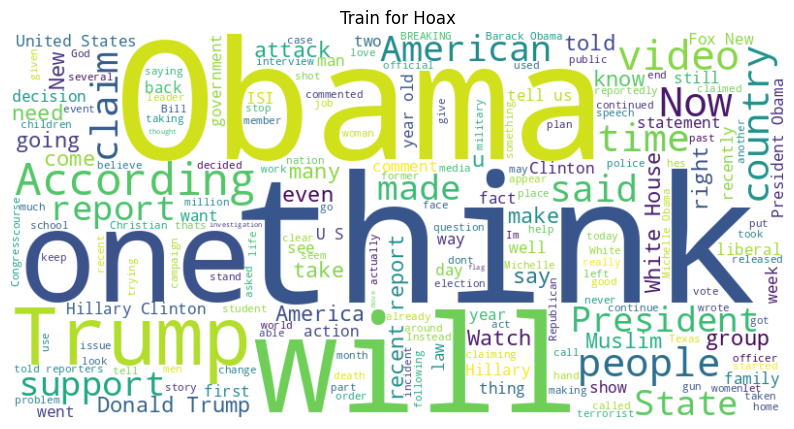

10 most frequent words:
obama: 4103
think: 3622
trump: 2704
just: 2202
president: 1983
according: 1793
video: 1791
people: 1688


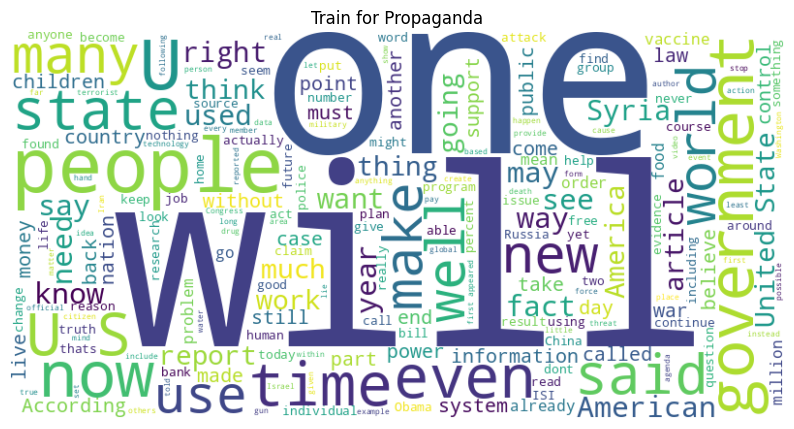

10 most frequent words:
people: 9320
government: 7912
just: 6218
like: 6132
new: 5536
world: 5523
time: 4794
state: 4501


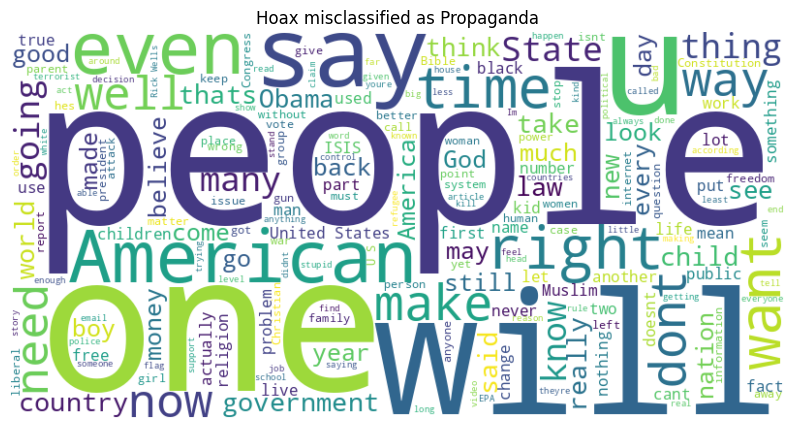

10 most frequent words:
people: 522
like: 345
just: 335
dont: 258
american: 174
right: 168
obama: 166
time: 162


In [32]:
error_error_analysis(train_df[train_df['Verdict'] == 2], title="Train for Hoax")
error_error_analysis(train_df[train_df['Verdict'] == 3], title="Train for Propaganda")
error_error_analysis(misclassified_df[(misclassified_df['Verdict'] == 2) & (misclassified_df['predicted'] == 3)], title="Hoax misclassified as Propaganda")

/Users/justinhoe/Desktop/Y4S2/4248/LUN/proj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.83      0.72      0.77       750
           2       0.74      0.71      0.72       750
           3       0.75      0.82      0.79       750
           4       0.83      0.90      0.86       750

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.79      0.79      0.78      3000

0.7849303935936454


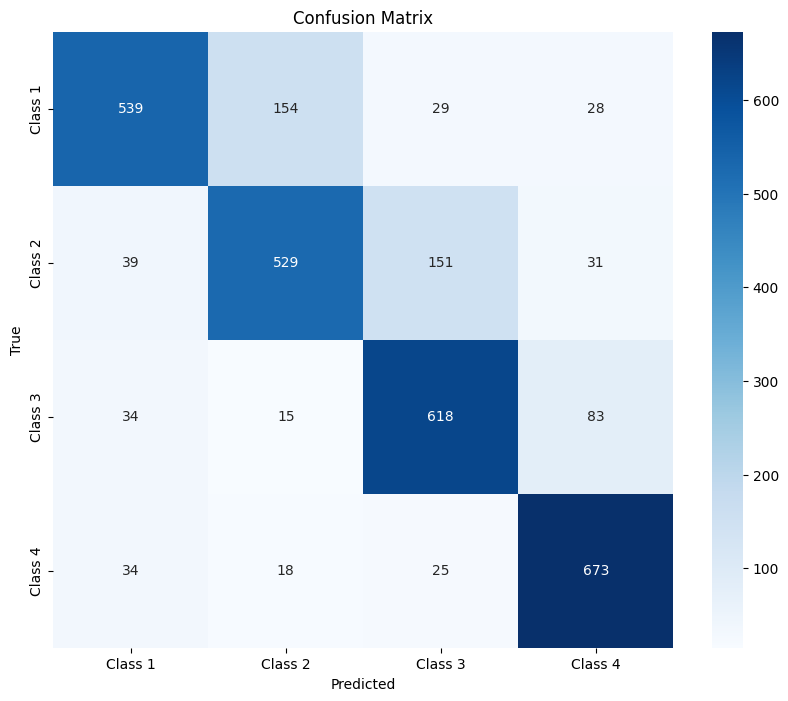

In [50]:
tm = tai_model(train_df, test_df, ["people"])

Hoax - 2 misclassified as propaganda - 3, due to people
Class 2 correct  + 1 
Class 3  correct + 3 
Class 4  correct + 4

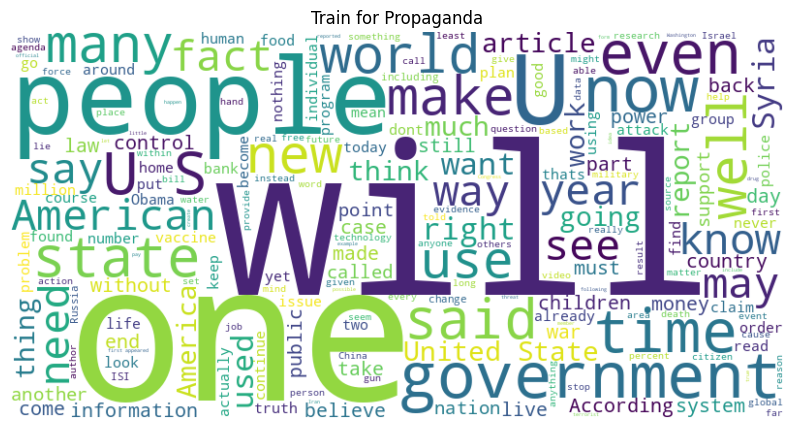

10 most frequent words:
people: 9320
government: 7912
just: 6218
like: 6132
new: 5536
world: 5523
time: 4794
state: 4501


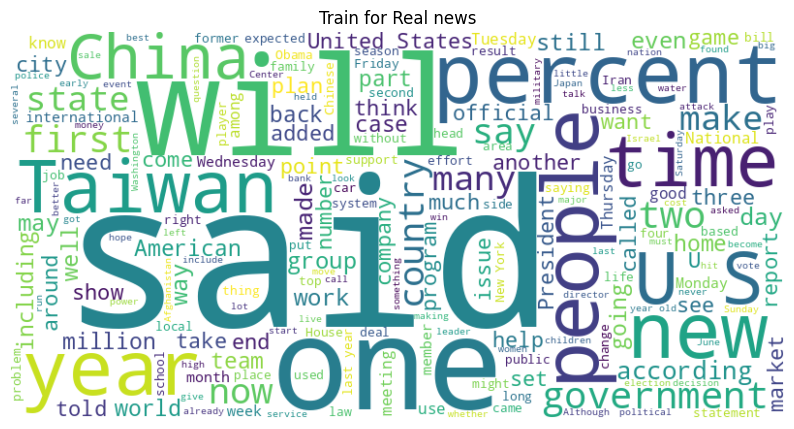

10 most frequent words:
said: 15831
percent: 3673
new: 3424
people: 3092
year: 3035
taiwan: 2850
government: 2683
president: 2387


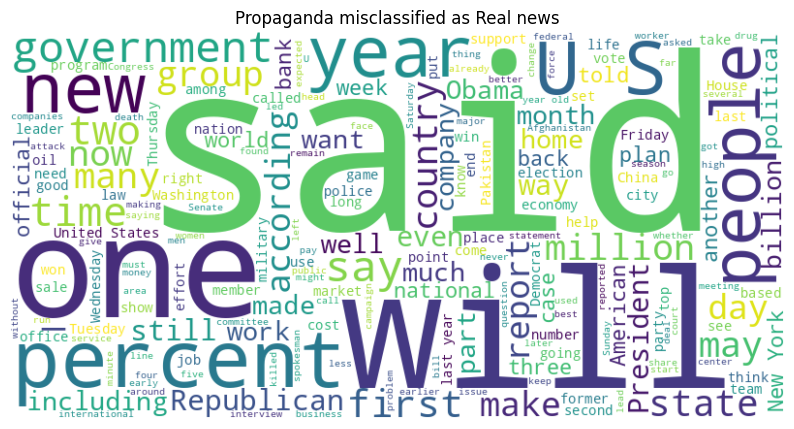

10 most frequent words:
said: 3481
percent: 907
new: 771
year: 654
people: 625
government: 580
obama: 465
president: 462


In [40]:
error_error_analysis(train_df[train_df['Verdict'] == 3], title="Train for Propaganda")
error_error_analysis(train_df[train_df['Verdict'] == 4], title="Train for Real news")
error_error_analysis(misclassified_df[(misclassified_df['Verdict'] == 4) & (misclassified_df['predicted'] == 4)], title="Propaganda misclassified as Real news")

Adding following to stop word performance for propaganda
StopWord Increase F1
Said        +4    0.779
percent     +4    0.779
new         +3    0.783
year        +2    0.779
government  +4    0.781
president   +2    0.779

All above words +7 0.75

/Users/justinhoe/Desktop/Y4S2/4248/LUN/proj/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.80      0.62      0.70       750
           2       0.68      0.70      0.69       750
           3       0.74      0.79      0.77       750
           4       0.81      0.90      0.85       750

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.75      0.75      3000

0.7516027622358953


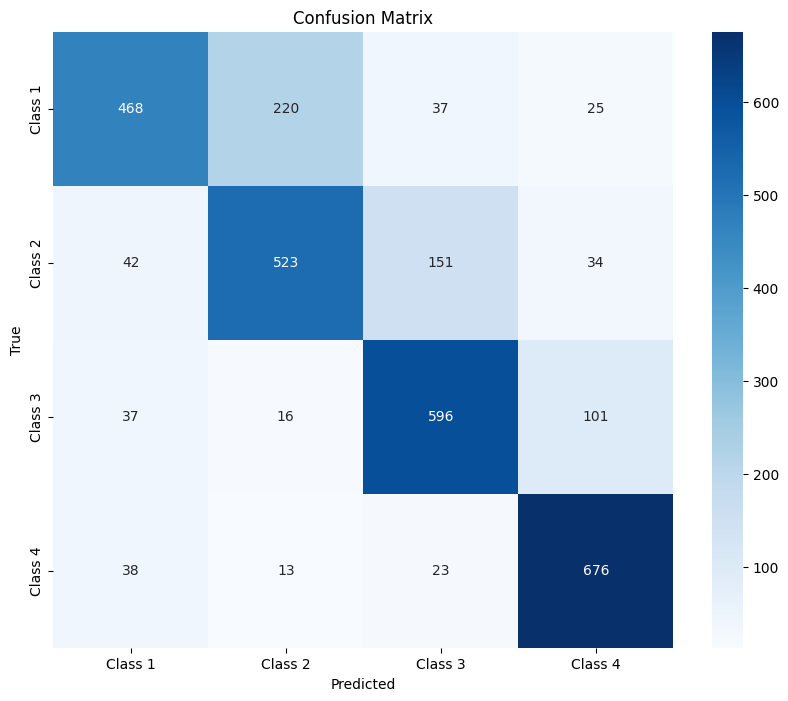

In [47]:
tm = tai_model(train_df, test_df, ["said","percent", "new", "year", "government","president"])